In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1",
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 332.0914, train_label_loss: 2.7753, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 11751.1950, train_label_loss: 2.6066, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 12765.0688, train_label_loss: 2.4976, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 13026.8007, train_label_loss: 2.2867, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 12975.7687, train_label_loss: 2.0016, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 12899.1176, train_label_loss: 1.9137, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 12943.2743, train_label_loss: 1.8101, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 13149.1386, train_label_loss: 1.4886, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 12894.4882, train_label_loss: 1.4904, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 12831.0487, train_label_loss: 1.3032, 


epoch: 1, source_val_acc_label: 0.5824, source_val_label_loss: 1.2751, target_val_acc_label: 0.5824, target_val_label_loss: 1.2751, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 14.1960, train_label_loss: 1.5375, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 12840.8207, train_label_loss: 1.2726, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 12921.2124, train_label_loss: 1.3734, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 12799.5828, train_label_loss: 1.0145, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 13189.7338, train_label_loss: 1.0663, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 12795.6410, train_label_loss: 1.3900, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 12774.2089, train_label_loss: 1.0498, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 12908.3372, train_label_loss: 0.9634, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 12869.1794, train_label_loss: 1.0597, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 13195.2393, train_label_loss: 0.8787, 


epoch: 2, source_val_acc_label: 0.6639, source_val_label_loss: 0.9568, target_val_acc_label: 0.6639, target_val_label_loss: 0.9568, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 14.6173, train_label_loss: 0.9808, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 12787.3283, train_label_loss: 0.9589, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 12918.2001, train_label_loss: 0.9113, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 12784.0583, train_label_loss: 0.9655, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 12716.0287, train_label_loss: 0.8632, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 12803.7569, train_label_loss: 0.7128, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 12925.4254, train_label_loss: 0.7402, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 12825.8924, train_label_loss: 1.1373, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 12846.5247, train_label_loss: 1.1478, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 12733.6012, train_label_loss: 0.9929, 


epoch: 3, source_val_acc_label: 0.7202, source_val_label_loss: 0.7830, target_val_acc_label: 0.7202, target_val_label_loss: 0.7830, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 14.6560, train_label_loss: 0.9206, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 12741.4011, train_label_loss: 0.7569, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 12800.0140, train_label_loss: 0.8218, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 12642.0062, train_label_loss: 0.7833, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 12693.8362, train_label_loss: 0.6987, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 12678.9725, train_label_loss: 0.7153, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 12687.8089, train_label_loss: 0.6958, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 12771.5634, train_label_loss: 0.5647, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 13818.3033, train_label_loss: 0.5835, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 13804.8733, train_label_loss: 0.6878, 


epoch: 4, source_val_acc_label: 0.7584, source_val_label_loss: 0.6679, target_val_acc_label: 0.7584, target_val_label_loss: 0.6679, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 17.2641, train_label_loss: 0.6810, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 16833.7265, train_label_loss: 0.8132, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 16886.6081, train_label_loss: 0.5465, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 16890.6328, train_label_loss: 0.6801, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 16970.4802, train_label_loss: 0.4506, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 16770.6912, train_label_loss: 0.5919, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 16944.3508, train_label_loss: 0.4912, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 16930.9467, train_label_loss: 0.7947, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 16901.2599, train_label_loss: 0.6921, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 16923.2379, train_label_loss: 0.6120, 


epoch: 5, source_val_acc_label: 0.7474, source_val_label_loss: 0.6846, target_val_acc_label: 0.7474, target_val_label_loss: 0.6846, 


epoch: 6, [batch: 1 / 7000], examples_per_second: 18.9869, train_label_loss: 0.4373, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 16083.0637, train_label_loss: 0.5366, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 16947.1115, train_label_loss: 0.3401, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 16976.5365, train_label_loss: 0.5390, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 16656.8118, train_label_loss: 0.4296, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 16438.3101, train_label_loss: 0.6519, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 16269.2141, train_label_loss: 0.5769, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 16751.9363, train_label_loss: 0.5711, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 16836.3265, train_label_loss: 0.5012, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 16853.0827, train_label_loss: 0.5194, 


epoch: 6, source_val_acc_label: 0.7739, source_val_label_loss: 0.6209, target_val_acc_label: 0.7739, target_val_label_loss: 0.6209, 


New best
epoch: 7, [batch: 1 / 7000], examples_per_second: 19.2310, train_label_loss: 0.5954, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 17005.0200, train_label_loss: 0.4085, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 16976.6384, train_label_loss: 0.4487, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 16983.2417, train_label_loss: 0.5214, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 16998.2709, train_label_loss: 0.4588, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 17005.5066, train_label_loss: 0.4037, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 16912.7437, train_label_loss: 0.7331, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 16968.9270, train_label_loss: 0.4114, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 16968.8381, train_label_loss: 0.4503, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 16779.3704, train_label_loss: 0.4980, 


epoch: 7, source_val_acc_label: 0.7742, source_val_label_loss: 0.6218, target_val_acc_label: 0.7742, target_val_label_loss: 0.6218, 


New best
epoch: 8, [batch: 1 / 7000], examples_per_second: 19.1268, train_label_loss: 0.4124, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 16312.9858, train_label_loss: 0.3875, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 16964.6305, train_label_loss: 0.6581, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 16595.1590, train_label_loss: 0.2681, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 12913.9581, train_label_loss: 0.5264, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 12418.7355, train_label_loss: 0.4784, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 12379.2356, train_label_loss: 0.4215, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 11743.2461, train_label_loss: 0.4022, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10673.7278, train_label_loss: 0.4404, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10680.7019, train_label_loss: 0.3519, 


epoch: 8, source_val_acc_label: 0.7749, source_val_label_loss: 0.6244, target_val_acc_label: 0.7749, target_val_label_loss: 0.6244, 


New best
epoch: 9, [batch: 1 / 7000], examples_per_second: 11.4314, train_label_loss: 0.3305, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 10615.8466, train_label_loss: 0.3533, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 10695.4161, train_label_loss: 0.3895, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 10694.7748, train_label_loss: 0.4418, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 10711.9645, train_label_loss: 0.3737, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 10670.1669, train_label_loss: 0.3723, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 10673.3852, train_label_loss: 0.4986, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 10702.0077, train_label_loss: 0.4983, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 10630.3313, train_label_loss: 0.3503, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 10651.6958, train_label_loss: 0.6303, 


epoch: 9, source_val_acc_label: 0.7582, source_val_label_loss: 0.6837, target_val_acc_label: 0.7582, target_val_label_loss: 0.6837, 


epoch: 10, [batch: 1 / 7000], examples_per_second: 11.5485, train_label_loss: 0.2915, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 10673.9099, train_label_loss: 0.3269, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 10712.4200, train_label_loss: 0.3435, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10690.8100, train_label_loss: 0.2530, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 10682.7285, train_label_loss: 0.4753, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 10708.7180, train_label_loss: 0.2587, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 10682.3692, train_label_loss: 0.2651, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 10632.5172, train_label_loss: 0.2042, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 10692.6369, train_label_loss: 0.3572, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 10670.1663, train_label_loss: 0.4791, 


epoch: 10, source_val_acc_label: 0.7695, source_val_label_loss: 0.6538, target_val_acc_label: 0.7695, target_val_label_loss: 0.6538, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 11.4146, train_label_loss: 0.4538, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 10642.7538, train_label_loss: 0.2093, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 10622.8442, train_label_loss: 0.2284, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 10652.4377, train_label_loss: 0.4630, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 10624.0923, train_label_loss: 0.2918, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 11513.7080, train_label_loss: 0.3718, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 11642.8890, train_label_loss: 0.2255, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 11734.4623, train_label_loss: 0.2356, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 11774.2381, train_label_loss: 0.4056, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 13015.9053, train_label_loss: 0.2261, 


epoch: 11, source_val_acc_label: 0.7786, source_val_label_loss: 0.6382, target_val_acc_label: 0.7786, target_val_label_loss: 0.6382, 


New best
epoch: 12, [batch: 1 / 7000], examples_per_second: 14.8394, train_label_loss: 0.2358, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 13156.9427, train_label_loss: 0.2339, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 13094.5261, train_label_loss: 0.3054, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 13172.1456, train_label_loss: 0.1694, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 11697.3350, train_label_loss: 0.1865, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 11768.2069, train_label_loss: 0.4369, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 12158.2257, train_label_loss: 0.2777, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 11017.6493, train_label_loss: 0.2847, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 10690.2535, train_label_loss: 0.2152, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 10665.4275, train_label_loss: 0.3490, 


epoch: 12, source_val_acc_label: 0.7734, source_val_label_loss: 0.6590, target_val_acc_label: 0.7734, target_val_label_loss: 0.6590, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 11.5813, train_label_loss: 0.1469, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 10706.1440, train_label_loss: 0.2240, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 10693.8530, train_label_loss: 0.4369, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 10699.7642, train_label_loss: 0.1649, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 10722.9998, train_label_loss: 0.2868, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 10700.1658, train_label_loss: 0.3210, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 10750.9085, train_label_loss: 0.2864, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 10775.8449, train_label_loss: 0.1760, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 10753.9089, train_label_loss: 0.3463, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 10755.9347, train_label_loss: 0.2034, 


epoch: 13, source_val_acc_label: 0.7793, source_val_label_loss: 0.6518, target_val_acc_label: 0.7793, target_val_label_loss: 0.6518, 


New best
epoch: 14, [batch: 1 / 7000], examples_per_second: 11.5769, train_label_loss: 0.1374, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 10736.2798, train_label_loss: 0.1367, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 10676.8785, train_label_loss: 0.1562, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 10721.0763, train_label_loss: 0.3329, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 10769.2034, train_label_loss: 0.4660, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 10716.6833, train_label_loss: 0.1900, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 10706.7245, train_label_loss: 0.2067, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 10709.4034, train_label_loss: 0.2073, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 10735.2531, train_label_loss: 0.4490, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 10688.2070, train_label_loss: 0.2525, 


epoch: 14, source_val_acc_label: 0.7646, source_val_label_loss: 0.7126, target_val_acc_label: 0.7646, target_val_label_loss: 0.7126, 


epoch: 15, [batch: 1 / 7000], examples_per_second: 11.5678, train_label_loss: 0.2370, 


epoch: 15, [batch: 700 / 7000], examples_per_second: 10702.6956, train_label_loss: 0.1078, 


epoch: 15, [batch: 1400 / 7000], examples_per_second: 10711.2571, train_label_loss: 0.1938, 


epoch: 15, [batch: 2100 / 7000], examples_per_second: 10725.5588, train_label_loss: 0.1956, 


epoch: 15, [batch: 2800 / 7000], examples_per_second: 10736.6814, train_label_loss: 0.2890, 


epoch: 15, [batch: 3500 / 7000], examples_per_second: 11758.5377, train_label_loss: 0.6849, 


epoch: 15, [batch: 4200 / 7000], examples_per_second: 11777.2498, train_label_loss: 0.1847, 


epoch: 15, [batch: 4900 / 7000], examples_per_second: 11772.2280, train_label_loss: 0.2259, 


epoch: 15, [batch: 5600 / 7000], examples_per_second: 12093.6518, train_label_loss: 0.3506, 


epoch: 15, [batch: 6300 / 7000], examples_per_second: 12926.1260, train_label_loss: 0.1579, 


epoch: 15, source_val_acc_label: 0.7688, source_val_label_loss: 0.7255, target_val_acc_label: 0.7688, target_val_label_loss: 0.7255, 


epoch: 16, [batch: 1 / 7000], examples_per_second: 14.8698, train_label_loss: 0.1429, 


epoch: 16, [batch: 700 / 7000], examples_per_second: 13152.4666, train_label_loss: 0.1358, 


epoch: 16, [batch: 1400 / 7000], examples_per_second: 13220.9108, train_label_loss: 0.2222, 


epoch: 16, [batch: 2100 / 7000], examples_per_second: 13063.3032, train_label_loss: 0.1323, 


epoch: 16, [batch: 2800 / 7000], examples_per_second: 11787.4367, train_label_loss: 0.1597, 


epoch: 16, [batch: 3500 / 7000], examples_per_second: 11753.5881, train_label_loss: 0.3181, 


epoch: 16, [batch: 4200 / 7000], examples_per_second: 12406.5915, train_label_loss: 0.2348, 


epoch: 16, [batch: 4900 / 7000], examples_per_second: 10814.7586, train_label_loss: 0.2140, 


epoch: 16, [batch: 5600 / 7000], examples_per_second: 10697.6225, train_label_loss: 0.2163, 


epoch: 16, [batch: 6300 / 7000], examples_per_second: 10742.1359, train_label_loss: 0.2361, 


epoch: 16, source_val_acc_label: 0.7676, source_val_label_loss: 0.7207, target_val_acc_label: 0.7676, target_val_label_loss: 0.7207, 


epoch: 17, [batch: 1 / 7000], examples_per_second: 11.6035, train_label_loss: 0.1647, 


epoch: 17, [batch: 700 / 7000], examples_per_second: 10688.8079, train_label_loss: 0.1313, 


epoch: 17, [batch: 1400 / 7000], examples_per_second: 10669.5408, train_label_loss: 0.3159, 


epoch: 17, [batch: 2100 / 7000], examples_per_second: 10715.0153, train_label_loss: 0.1670, 


epoch: 17, [batch: 2800 / 7000], examples_per_second: 10705.7808, train_label_loss: 0.2183, 


epoch: 17, [batch: 3500 / 7000], examples_per_second: 10695.2813, train_label_loss: 0.1703, 


epoch: 17, [batch: 4200 / 7000], examples_per_second: 10729.1308, train_label_loss: 0.3531, 


epoch: 17, [batch: 4900 / 7000], examples_per_second: 10713.5411, train_label_loss: 0.2684, 


epoch: 17, [batch: 5600 / 7000], examples_per_second: 10710.5974, train_label_loss: 0.2548, 


epoch: 17, [batch: 6300 / 7000], examples_per_second: 10695.4456, train_label_loss: 0.1218, 


epoch: 17, source_val_acc_label: 0.7732, source_val_label_loss: 0.7290, target_val_acc_label: 0.7732, target_val_label_loss: 0.7290, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

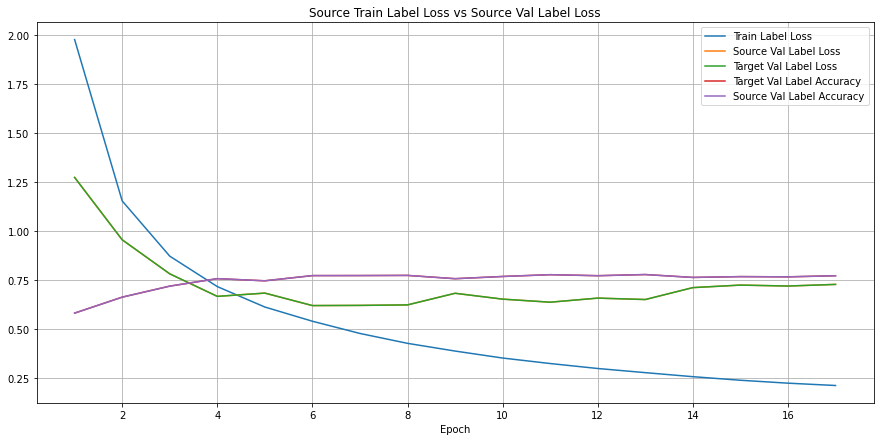

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

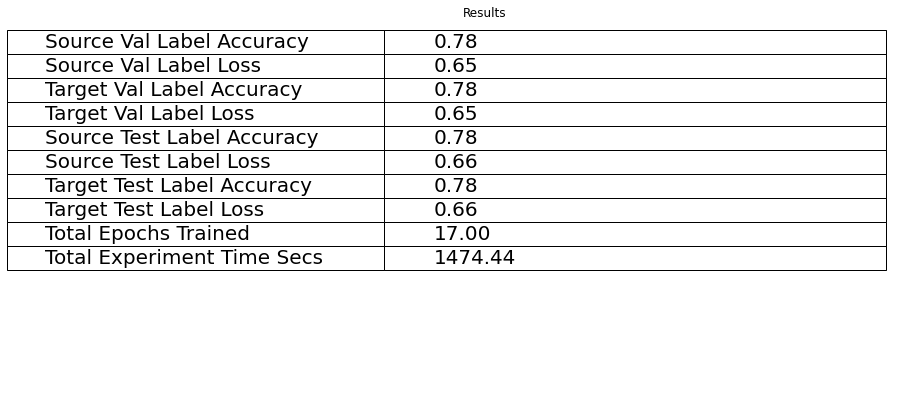

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

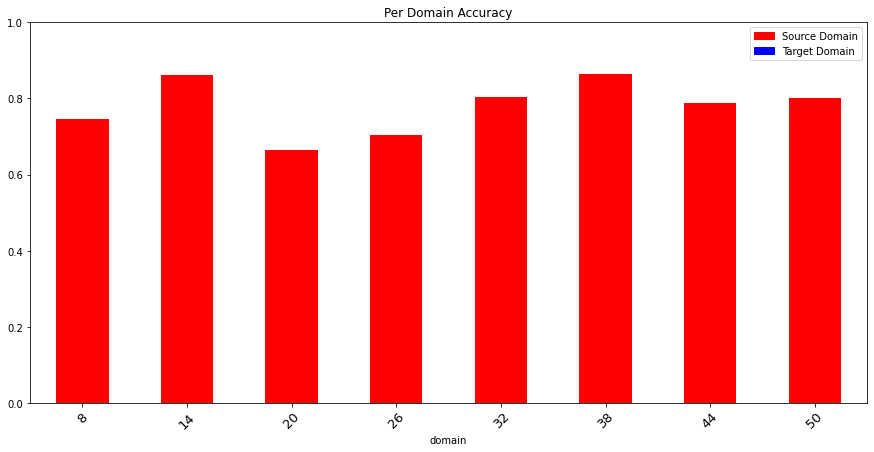

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.777484375 Target Test Label Accuracy: 0.777484375
Source Val Label Accuracy: 0.779328125 Target Val Label Accuracy: 0.779328125


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1", "parameters": {"experiment_name": "cnn_2:oracle.run1", "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [